In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_circles
from scipy.special import expit
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report

C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
seed = 42
np.random.seed(seed)

In [3]:
class LogisticRegressor:

    def error_function(self, x, y, a):    
        h = expit(x.dot(a))
        error = -(1/len(y))*np.sum(y.T.dot(np.log(h)) + (1-y).T.dot(np.log((1-h) )))
        return error

    def predict(self, x, a):
        h = expit(x.dot(a))
        c = np.zeros((len(h), 1))
        for i in range(0, len(h)):
            if(h[i] >= 0.5):
                c[i,0] = 1.0
        return c
    
    def predict_proba(self, x, a):
        h = expit(x.dot(a))
        return h

    def predict_proba2(self, x, a):
        h1 = expit(x.dot(a))
        h0 = 1 - h1
        h = np.c_[h0, h1]
        return h
    
    def fit(self, x_train, y_train, x_test, y_test, alpha, n_iterations, seed):
        # Reset PN sequence generator.
        np.random.seed(seed)
        
        # Random initialization of parameters.
        a = np.random.randn(x_train.shape[1], 1)

        # Create array for storing error values.
        Jgd = np.zeros(n_iterations+1)
        Jgd_v = np.zeros(n_iterations+1)

        # Calculate initial error.
        Jgd[0] = self.error_function(x_train, y_train, a)
        Jgd_v[0] = self.error_function(x_test, y_test, a)

        # Batch gradient-descent loop.
        minimum_val_error = float("inf")
        error = float("inf")
        iteration = 0
        while iteration < n_iterations:
            gradients = -1/len(y_train)*x_train.T.dot(y_train - expit(x_train.dot(a)) )
            a = a - alpha * gradients
            Jgd[iteration+1] = self.error_function(x_train, y_train, a)
            Jgd_v[iteration+1] = self.error_function(x_test, y_test, a)
            error = np.abs(Jgd[iteration+1] - Jgd[iteration])
            # Store weights for the smallest error ever.
            if(Jgd_v[iteration+1] < minimum_val_error):
                minimum_val_error = Jgd_v[iteration+1]
                a_min = a        
            iteration += 1
        return a_min, minimum_val_error, iteration, Jgd, Jgd_v

In [4]:
# Number of examples.
M = 1000

# Create 4-class dataset for classification.
centers = [[-5, 0], [0, 1.5], [5, -1], [10, 1.5]]
x, y = make_blobs(n_samples=M, centers=centers, random_state=seed)

Y = y

y = y/1.0;

y = y.reshape(len(y), 1)

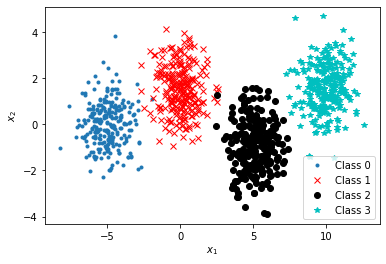

In [5]:
idx0 = np.argwhere(Y == 0)
idx1 = np.argwhere(Y == 1)
idx2 = np.argwhere(Y == 2)
idx3 = np.argwhere(Y == 3)

plt.plot(x[idx0,0], x[idx0,1], '.', label='Class 0')
plt.plot(x[idx1,0], x[idx1,1], 'rx', label='Class 1')
plt.plot(x[idx2,0], x[idx2,1], 'ko', label='Class 2')
plt.plot(x[idx3,0], x[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

# Um-Contra-o-Resto

### Classe 1 versus Resto

In [6]:
y_mod1 = y.copy()
y_mod1[idx0] = 1
y_mod1[idx1] = 0
y_mod1[idx2] = 0
y_mod1[idx3] = 0

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y_mod1, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [7]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf1 = LogisticRegressor()
a_min1, minimum_val_error, iteration, Jgd, Jgd_v = clf1.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

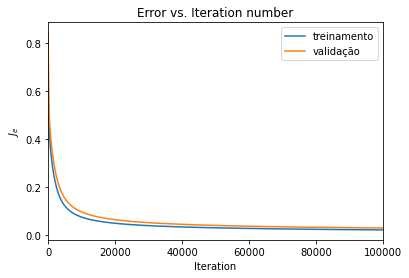

In [8]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 2 versus Resto

In [9]:
y_mod2 = y.copy()
y_mod2[idx0] = 0
y_mod2[idx1] = 1
y_mod2[idx2] = 0
y_mod2[idx3] = 0

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y_mod2, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [10]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf2 = LogisticRegressor()
a_min2, minimum_val_error, iteration, Jgd, Jgd_v = clf2.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

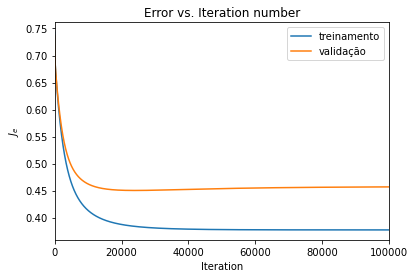

In [11]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 3 versus Resto

In [12]:
y_mod3 = y.copy()
y_mod3[idx0] = 0
y_mod3[idx1] = 0
y_mod3[idx2] = 1
y_mod3[idx3] = 0

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y_mod3, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [13]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf3 = LogisticRegressor()
a_min3, minimum_val_error, iteration, Jgd, Jgd_v = clf3.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

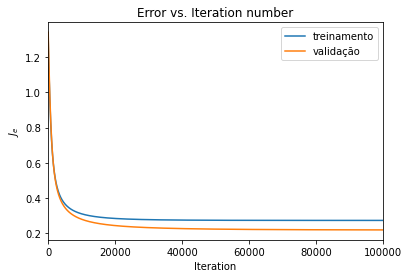

In [14]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 4 versus Resto

In [15]:
y_mod4 = y.copy()
y_mod4[idx0] = 0
y_mod4[idx1] = 0
y_mod4[idx2] = 0
y_mod4[idx3] = 1

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y_mod4, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [16]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf4 = LogisticRegressor()
a_min4, minimum_val_error, iteration, Jgd, Jgd_v = clf4.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

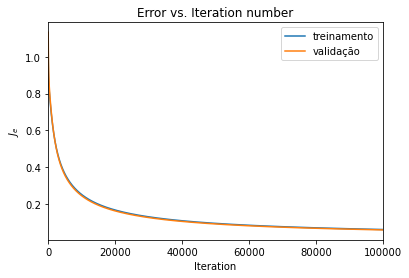

In [17]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Predição

In [18]:
X = np.c_[np.ones((len(y), 1)), x]

y_pred = np.zeros((M, 1))
for i in range(0, M):
    h1 = clf1.predict_proba(X[i,:], a_min1)
    h2 = clf2.predict_proba(X[i,:], a_min2)
    h3 = clf3.predict_proba(X[i,:], a_min3)
    h4 = clf4.predict_proba(X[i,:], a_min4)
    y_pred[i] = np.argmax([h1[0],h2[0],h3[0],h4[0]])

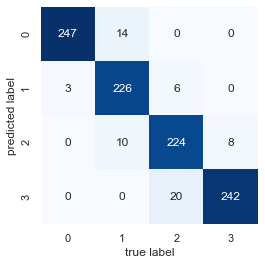

In [19]:
# Plot the confusion matrix
mat = confusion_matrix(y, y_pred)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2','3'], yticklabels=['0','1','2','3'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [20]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       250
         1.0       0.96      0.90      0.93       250
         2.0       0.93      0.90      0.91       250
         3.0       0.92      0.97      0.95       250

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [21]:
# Calculate accuracy of class predictions.
accuracy_score(y, y_pred)

0.939

# Um-Contra-Um

### Classe 1 versus 2

In [22]:
idxC1 = idx0.ravel()
idxC2 = idx1.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [23]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf1 = LogisticRegressor()
a_min1, minimum_val_error, iteration, Jgd, Jgd_v = clf1.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

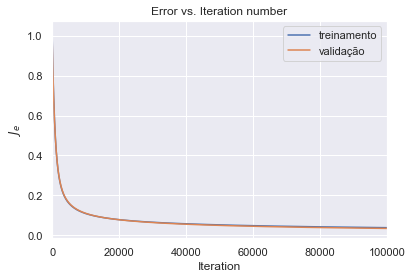

In [24]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 1 versus 3

In [25]:
idxC1 = idx0.ravel()
idxC2 = idx2.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [26]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf2 = LogisticRegressor()
a_min2, minimum_val_error, iteration, Jgd, Jgd_v = clf2.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

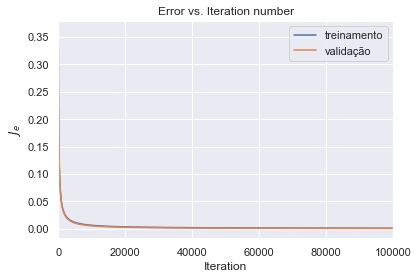

In [27]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 1 versus 4

In [28]:
idxC1 = idx0.ravel()
idxC2 = idx3.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [29]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf3 = LogisticRegressor()
a_min3, minimum_val_error, iteration, Jgd, Jgd_v = clf3.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

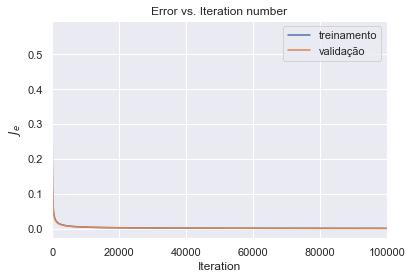

In [30]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 2 versus 3

In [31]:
idxC1 = idx1.ravel()
idxC2 = idx2.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [32]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf4 = LogisticRegressor()
a_min4, minimum_val_error, iteration, Jgd, Jgd_v = clf4.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

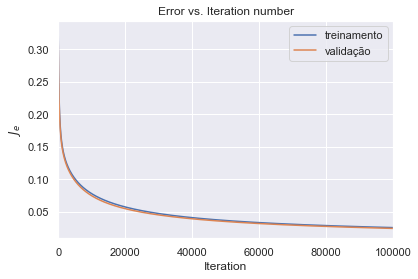

In [33]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 2 versus 4

In [34]:
idxC1 = idx1.ravel()
idxC2 = idx3.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [35]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf5 = LogisticRegressor()
a_min5, minimum_val_error, iteration, Jgd, Jgd_v = clf5.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

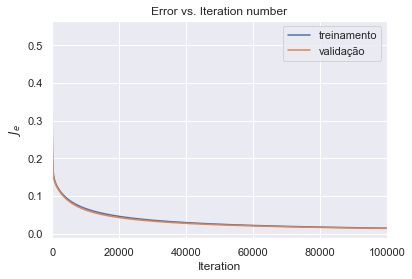

In [36]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Classe 3 versus 4

In [37]:
idxC1 = idx2.ravel()
idxC2 = idx3.ravel()

y_mod = y.copy()
y_mod[idxC1] = 1
y_mod[idxC2] = 0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]
x_mod = np.r_[x[idxC1],  x[idxC2]]

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.3, random_state=seed)

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [38]:
# learning rate.
alpha = 0.001
# Maximum number of iterations.
n_iterations = 100000

clf6 = LogisticRegressor()
a_min6, minimum_val_error, iteration, Jgd, Jgd_v = clf6.fit(x_train, y_train, x_test, y_test, alpha, n_iterations, seed)

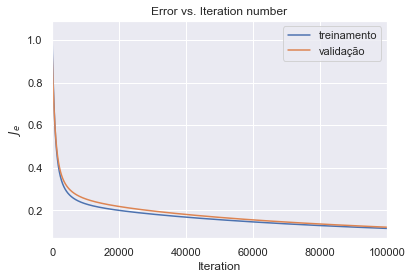

In [39]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

### Predição

In [40]:
X = np.c_[np.ones((len(y), 1)), x]

y_pred = np.zeros((M, 1))
for i in range(0, M):
    classes = np.zeros((4,))
    
    if(clf1.predict(X[i,:], a_min1) == 1):
        classes[0] += 1
    else:
        classes[1] += 1
    
    if(clf2.predict(X[i,:], a_min2) == 1):
        classes[0] += 1
    else:
        classes[2] += 1        
    
    if(clf3.predict(X[i,:], a_min3) == 1):
        classes[0] += 1
    else:
        classes[3] += 1      
    
    if(clf4.predict(X[i,:], a_min4) == 1):
        classes[1] += 1
    else:
        classes[2] += 1 
    
    if(clf5.predict(X[i,:], a_min5) == 1):
        classes[1] += 1
    else:
        classes[3] += 1     
    
    if(clf6.predict(X[i,:], a_min6) == 1):
        classes[2] += 1
    else:
        classes[3] += 1    

    y_pred[i] = np.argmax(classes)

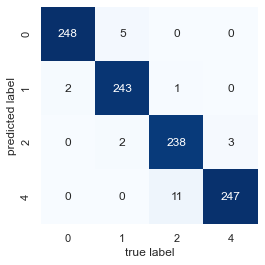

In [41]:
# Plot the confusion matrix
mat = confusion_matrix(y, y_pred)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2','4'], yticklabels=['0','1','2','4'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [42]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       250
         1.0       0.99      0.97      0.98       250
         2.0       0.98      0.95      0.97       250
         3.0       0.96      0.99      0.97       250

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [43]:
# Calculate accuracy of class predictions.
accuracy_score(y, y_pred)

0.976